### IMBH Forecast

TODO:
- obscured fraction
- dust extinction/reddening effects
- 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
from scipy.optimize import minimize

def simulate_drw(t_rest, tau=300., z=2.0, xmean=0, SFinf=0.3):

    N = len(t_rest)
    
    t_obs = t_rest*(1 + z)/tau
    
    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)
    
    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1] - dt * (x[i - 1] - xmean) + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))
    
    return x


# Redshift
z = 2

# MJDs
num_seasons = 6 # years
season_duration = 200 # days
cadence = 7 # days
t = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
t = np.sort(np.array(t).flatten())
t_rest = t/(1 + z)

t_eval = np.arange(np.min(t), np.max(t), cadence/10)

# mag error
dy = 0.02

# Fixed parameters
tau = 200
tau_obs = tau*(1 + z)
sigma = 0.1

# Simulate light curve
SFinf = np.sqrt(2)*sigma
y = simulate_drw(t_rest, tau=tau, z=z, xmean=18, SFinf=SFinf) # mag

# uncertainties
yerr = np.full(np.shape(y), dy)
y += np.random.normal(0, dy, len(y))

# Add 5 random outliers
num_outliers = 5
indx = np.random.choice(len(y), num_outliers)
print(indx)
y[indx] += np.random.normal(0, 50*dy, num_outliers)

# Celerite's form
log_c = np.log(1/tau_obs)
log_a = np.log(2*sigma**2)

# GP object
kernel = celerite.terms.RealTerm(log_a=log_a, log_c=log_c) # DRW kernel
gp = celerite.GP(kernel, mean=np.mean(y), fit_mean=False)

gp.compute(t)

# Normally we do MCMC here
# Instead, set samples array directly
samples = np.array([[log_a, log_c],])

s = np.median(samples, axis=0)
gp.set_parameter_vector(s)

for i in range(len(t)):

    # Get MLE solution
    """
    # Define a cost function
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y) # Could try other likelihood functions for outliers

    def grad_neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)[1]

    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(soln.x)
    print("Final log-likelihood: {0}".format(-soln.fun))
    """

    # See https://celerite.readthedocs.io/en/stable/python/gp/
    mu, var = gp.predict(y[i], t_eval, return_var=True)
    std = np.sqrt(var)

    # Draw a random sample from the conditional prediction
    #y_cond = gp.sample_conditional(y, t_eval, size=1) # Note this is O(t_eval^3) SLOW ...

    #print(std) # Doesn't seem to work, gives many NaNs
    # Maybe you could change size in sample_conditional to a larger number and get the variance of that

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.errorbar(t, y, yerr=yerr, c='k', fmt='.', alpha=0.75, elinewidth=1, label='simulated data')
ax.plot(t_eval, mu, color="#ff7f0e", alpha=1, label='conditional prediction')
#ax.fill_between(t_eval, mu+std, mu-std, color="#ff7f0e", alpha=0.3, label='conditional prediction error')

#ax.plot(t_eval, y_cond[0,:], color="lightblue", alpha=0.8, label='conditional prediction sample')

ax.set_xlabel('Time (MJD)',fontsize=18)
ax.set_ylabel(r'Magnitude',fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(np.max(y) + .1, np.min(y) - .1)
ax.set_xlim(np.min(t), np.max(t))
ax.legend(fontsize=16, loc=1)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle
from taufit import simulate_from_psd, smoothly_broken_power_law, fit_drw

from tqdm.notebook import tqdm

import scipy.stats as st

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

In [2]:
from model import DemographicModel, ERDF_blue, ERDF_red, calc_sigma_var, lambda_obs

In [3]:
def set_mpl_style():
    
    """Function to set MPL style"""
    
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 1.8
    lhandle = 2.0
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [4]:
set_mpl_style()

No handles with labels found to put in legend.


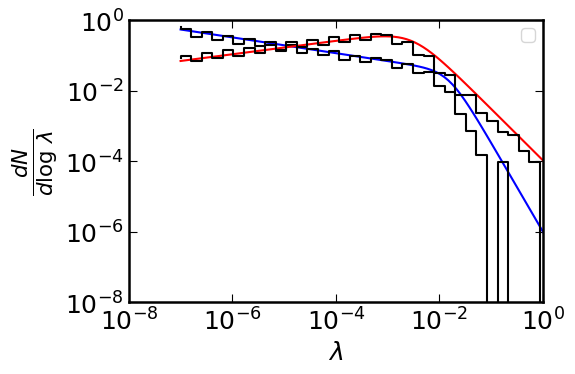

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

l = np.logspace(-7, 1, 100)
dlogl = np.diff(np.log10(l))[0]

colors =['b', 'r']

for i, ERDF in enumerate([ERDF_blue, ERDF_red]):

    p = ERDF(l)*dlogl
    p = p/np.sum(p)
    s = np.random.choice(l, 100000, p=p)

    ax.loglog(l, p/dlogl, c=colors[i])

    bins = np.logspace(-7, 3, 50)
    h, bin_edges = np.histogram(s, bins=bins)
    ax.step(bin_edges[:-1], h/np.diff(np.log10(bins))[0]/len(s), color='k')

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel(r'$\frac{dN}{d\log\ \lambda}$', fontsize=22)

ax.legend(fontsize=12)

ax.tick_params('both', labelsize=18)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlim(1e-8, 1e0)
ax.set_ylim(1e-8, 1e0)

fig.tight_layout()

### Load previous model instance

In [6]:
# May need to run one at a time to save memory
keys = ['ptf']

In [ ]:
nbootstrap = 2 # =16
nbins = 20 # =20

# Assuming ~SDSS solid angle
omegas = {'ptf':14000*u.deg**2, 'lsst':18000*u.deg**2, 'des-sn':4.64*u.deg**2}
zmaxes = {'ptf':0.055, 'lsst':0.055, 'des-sn':1.5}
ndraws = {'ptf':5e8, 'lsst':5e8, 'des-sn':4e9}
etas = {'ptf':10, 'lsst':10, 'des-sn':10}

bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g', 'des-sn':'SDSS_g'}

models = {}
for key in keys:
    models[key] = DemographicModel()
    omega_sr = omegas[key].to(u.sr).value
    models[key].sample(nbins=nbins, nbootstrap=nbootstrap, zmax=zmaxes[key], eta=etas[key],
                       ndraw_dim=ndraws[key]/etas[key], omega=omega_sr, ERDF_mode=0)
    #, seed_dict={'dc':(lambda x: np.ones_like(x))})
    

Using Reines et al. 2015 host-BH mass relation for low redshifts


  0%|          | 0/2 [00:00<?, ?it/s]

### Host galaxy colors and dilution

In [ ]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
# Load NASA Sloan Atlas (DR13)
hdul_nsa = fits.open('/data3/nsa_v0_1_2.fits') ## OLD VERSION!
data_nsa = hdul_nsa[1].data

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
g = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) # g
r = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,4]) # r

R = r - 0.1837*(g-r) - 0.0971

print(17.7 - 0.1837*0.4 - 0.0971)

ax.hist(R, bins=np.linspace(14, 21), color='gray', histtype='step', lw=2);
#ax.set_yscale('log')

In [ ]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

def plot_results(X, Y_, means, covariances, index, ax=None, title=None, colors=['b','r','k'], alphas=None):
    #splot = plt.subplot(2, 1, 1 + index)
    ax = ax or plt.gca()
    
    if alphas is None: alphas = np.ones(len(means))
    color_iter = itertools.cycle(colors)
    
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        if X is not None:
            ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color, zorder=-100)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, fc='none', lw=1.5, ec=color)
        
        ell.set_clip_box(plt.gcf().bbox)
        ell.set_alpha(alphas[i])
        ax.add_artist(ell)

    #plt.xlim(-9.0, 5.0)
    #plt.ylim(-3.0, 6.0)
    #plt.xticks(())
    #plt.yticks(())
    ax.set_title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
X = np.r_[
    np.dot(np.random.randn(n_samples, 2), C),
    0.7 * np.random.randn(n_samples, 2) + np.array([-6, 3]),
]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type="full").fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, title="Gaussian Mixture")
plt.show()

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    title="Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.show()

In [ ]:
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

# Data
g = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) # g
r = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,4]) # r
stellar_mass = data_nsa['MASS'] * (0.7)**2

# GMM
thin = 10
mask_nan = np.isfinite(g-r) & np.isfinite(np.log10(stellar_mass))
#mask_outlier = (np.log10(stellar_mass) > 6) & (np.log10(stellar_mass) < 12) & ((g-r) > 0) & ((g-r) < 1.2)

x = np.log10(stellar_mass)[mask_nan][::thin]
y = (g-r)[mask_nan][::thin]
X = np.array([x, y]).T

gmm = BayesianGaussianMixture(n_components=3, covariance_type="full", random_state=1).fit(X)
labels = gmm.predict(X)

mask_na = np.isfinite(stellar_mass) & np.isfinite(g-r)

xx, yy = np.mgrid[5:12:20j, 0:1.2:20j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cfset = ax.contourf(xx, yy, f, levels=20, cmap='binary')

ax.set_ylim([0.0, 1.2])
ax.set_xlim([6, 12])

plot_results(None, gmm.predict(X), gmm.means_, gmm.covariances_, 0, ax=ax, alphas=[0.8, 0.8, 0], colors=['b','r','k'])
print('mu =', gmm.means_)
print('cov =',gmm.covariances_)
print('sigma =',np.sqrt(np.diagonal(gmm.covariances_, axis1=1, axis2=2)))

# Bell 2003 slope
x_eval = np.linspace(4, 13)
plt.plot(x_eval, 0.03*x_eval + 0.4, lw=2, color='k', linestyle='dashed')

ax.set_ylabel(r'$g - r$')
ax.set_xlabel(r'$\log(M_{\star}/M_{\odot})$')

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('color.pdf', dpi=300)

In [ ]:
size = 2000

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

mu = np.array([8.9846321,  0.46562084])
cov = np.array([[0.52527681, 0.06516369],
               [0.06516369,  0.0229178]])
rv_blue = st.multivariate_normal(mean=mu, cov=cov)
rvs = rv_blue.rvs(size=size)
plt.scatter(rvs[:,0], rvs[:,1], color='b', alpha=0.1, marker='.')

mu = np.array([9.77213478, 0.79589641])
cov = np.array([[0.23671096, 0.0184602],
                [0.0184602,  0.00646298]])
rv_red = st.multivariate_normal(mean=mu, cov=cov)
rvs = rv_red.rvs(size=size)
plt.scatter(rvs[:,0], rvs[:,1], color='r', alpha=0.1, marker='.')

plot_results(None, gmm.predict(X), gmm.means_, gmm.covariances_, 0, ax=ax, alphas=[1, 1, 0], colors=['b','r','k'])

ax.set_ylim([0.0, 1.2])
ax.set_xlim([6, 12])

In [ ]:
x_in=9

y = np.linspace(0, 1.2)
x = np.full_like(y, x_in)
pdf = rv_blue.pdf(x=np.array([x,y]).T)

a = np.random.choice(y, size=1000, p=pdf/np.sum(pdf)) 

plt.hist(a, density=True)
plt.plot(y, pdf)

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

# Use a Gaussian mixture model to define the two probability clouds and
# then given the stellar mass, get g-r

In [ ]:
from scipy.optimize import curve_fit

M_star_bins = np.arange(5, 11, 1)

# FUV NUV u g r i z 
f_host = data_nsa['FIBERFLUX'][:,3]/data_nsa['PETROFLUX'][:,3]
stellar_mass = data_nsa['MASS'] * (0.7)**2

# Overall values

mask_na = np.isfinite(data_nsa['Z']) & (f_host<1) & (f_host>0)

fig, axs = plt.subplots(len(M_star_bins)//2, 2, figsize=(2*5.3, len(M_star_bins)//2*3.8))

xx, yy = np.mgrid[0:0.055:20j, -3:0:20j]
positions = np.vstack([xx.ravel(), yy.ravel()])


# Define the fitting function
def func(x, a, b, c):
    #x = np.log10(1 + x)
    x = x-a
    return 1 - 1/(x**2 + b*x + c)


# Mass bin loop
for i, M_star in enumerate(M_star_bins):
    ax = axs.flatten()[i]
    
    bin_lo = 10**M_star_bins[i]
    bin_hi = 10**(M_star_bins[i] + 1)
    
    mask_na = np.isfinite(data_nsa['Z']) & (f_host<1) & (f_host>0) & (stellar_mass > bin_lo) & (stellar_mass < bin_hi)
    values = np.vstack([data_nsa['Z'][mask_na], np.log10(f_host[mask_na])])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    cfset = ax.contourf(xx, yy, f, levels=20, cmap='binary')
    

    #ax.scatter(data_nsa['Z'], np.log10(f_host), s=0.001, c='gray')
    ax.set_ylim([-2.8, 0])
    ax.set_xlim([0, 0.055])

    p, pcov = curve_fit(func, data_nsa['Z'][mask_na], f_host[mask_na])
    x = np.linspace(0, 0.06)
    ax.plot(x, np.log10(func(x, *p)), color='k')

    print(p)

    res = np.log10(f_host[mask_na]) - np.log10(func(data_nsa['Z'][mask_na], *p))

    rms = np.nanstd(res)
    print(np.nanstd(res))

    ax.plot(x, np.log10(func(x, *p)) - rms, color='k', linestyle='dotted')
    ax.plot(x, np.log10(func(x, *p)) + rms, color='k', linestyle='dotted')

    ax.set_ylabel(r'$\log(f_{\star, {\rm{3^{\prime\prime}}}})$')
    ax.set_xlabel(r'Redshift')
    
    ax.text(0.028, -2.5, fr'${M_star_bins[i]} < \log(M_\star/M_\odot) < {M_star_bins[i] + 1}$', fontsize=12)

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
fig.savefig('fhost.pdf', dpi=300)

### Plot model summary figure

In [ ]:
pars = {}
for key in keys:
    pars[key] = models[key].pars

stellar_mass = data_nsa['MASS'] * (0.7)**2
M_star_ = pars[keys[0]]['M_star_'].value
M_star = pars[keys[0]]['M_star'].value
n_i, _ = np.histogram(stellar_mass, bins=M_star_)
dlogM_star = np.diff(np.log10(M_star_))

print(len(stellar_mass[stellar_mass>0]))

omega = (9380*u.deg**2).to(u.sr) # DR8 https://www.sdss3.org/dr8/
V = cosmo.comoving_volume(0.055)*omega/(4*np.pi)
phi_i = n_i/V/dlogM_star

def phi_X(L_X):
    # https://iopscience.iop.org/article/10.1088/0004-637X/749/1/21/pdf
    
    A = 113.1*1e-7
    L_br = 0.51*1e44
    gamma1 = 0.79
    gamma2 = 2.39
    # z=0
    return A/(np.log(10)) * ((L_X/L_br)**gamma1 + (L_X/L_br)**gamma2)**-1 #1/L_X

In [ ]:
plot = True

if plot and etas[key] >= 1:

    fig_ptf = models[keys[0]].plot(n_bin_min=10)
    #fig_lsst = model_lsst.plot()

    axs = fig_ptf.axes
    axs[0].scatter(M_star, phi_i, marker='o', facecolors='none', edgecolors='r')
    
    L_X = np.logspace(41, 46)
    dlogL_X = np.diff(np.log10(L_X))[0]
    axs[-1].plot(L_X/1e-1, phi_X(L_X)/dlogL_X, color='r')

    fig_ptf.savefig('model.pdf', dpi=300)

In [ ]:
# In the Weigel paper they have not assigned every galaxy an Eddington ratio, instead use the X-ray or radio selected AGNs
# Here, we want to assign every galaxy an Eddington ratio, so need to adjust the normalization
# Need more galaxies with smaller lambda_Edd!
# Since the delta1 slope is not well-constrained by the bolometric AGN LF, we adjust it to match the the LF as a free parameter

### Sample grid of SEDs

In [ ]:
for key in keys:
    models[key].sample_sed_grid(band=bands[key])

In [ ]:
hdul = fits.open('sed_grid.fits')
hdul[0].header

In [ ]:
hdul[0].data.shape

In [ ]:
m_5 = {'ptf':20.5, 'lsst':25.0, 'des-sn':24.5}

band_names = {'ptf':'R', 'lsst':'g', 'des-sn':'g'}

labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}

### Mock Observations: light curves

PTF:

In [ ]:
if 'ptf' in keys:

    num_seasons = 4 # years
    season_duration = 95 # days
    cadence = 5 #5 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()

    models['ptf'].sample_light_curves(t_obs, band=bands['ptf'], dt_min=1, m_5=m_5[key])

LSST:

In [ ]:
if 'lsst' in keys:

    num_seasons = 10 # years
    season_duration = 95 # days
    cadence = 25 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()

    models['lsst'].sample_light_curves(t_obs, band=bands['lsst'], dt_min=cadence//2, m_5=m_5[key])

DES-SN

In [ ]:
if 'des-sn' in keys:

    num_seasons = 6 # years
    season_duration = 95 # days
    cadence = 7 #5 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()

    models['des-sn'].sample_light_curves(t_obs, band=bands['des-sn'], dt_min=cadence//2)

LSST hybrid

In [ ]:
special = False

if 'lsst' in keys and special:

    # LSST Special
    num_seasons = 1
    season_duration = 5 # days
    cadence = 0.1 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()
    
    num_seasons = 10
    season_duration = 95 # days
    cadence = 25 # days
    t_obs2 = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs2 = np.array(t_obs2).flatten()
    
    t_obs = np.sort(np.concatenate([t_obs, t_obs2]))

    models['lsst'].sample_light_curves(t_obs, band=bands['lsst'],  dt_min=0.1/2)

In [ ]:
pars = {}
samples = {}
for key in keys:
    pars[key] = models[key].pars
    samples[key] = models[key].samples

#np.save('s_lsst.npy', s_lsst)
#np.save('s_ptf.npy', s_ptf)

In [ ]:
samples[key].keys()

In [ ]:
j = 0
bins = 16
fig, axs = plt.subplots(1, 2, figsize=(2*5, 4))


for k, (key, s) in enumerate(samples.items()):
    
    print(key)
    
    band = bands[key]
    seed_keys = list(pars[key]['seed_dict'].keys())
    colors = ['b','m']
    
    for i, seed in enumerate(seed_keys):
        
        # Redshift distributions are identical for all seeding scenarios
        if i > 0:
            continue
    
        ndraw_dim = int(np.max(samples[key]['ndraws']))
        
        g = 17.8
        g_minus_r = 0.5
        R = g - 0.1837*g_minus_r - 0.0971

        # Redshift
        mask_na = np.isfinite(data_nsa['Z'])
        mask_mag = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) < g
        axs[0].hist(data_nsa['Z'][mask_mag & mask_na], color='gray', zorder=0, density=False, fill=None,
                     linestyle='dashed', lw=2, histtype='step', bins=bins, label='NASA Sloan Atlas')

        z = s[f'z_draw'][j,:ndraw_dim]
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < R
        axs[0].hist(z[mask_mag], color='red', zorder=-1, density=False, fill=None, lw=2.5, histtype='step', bins=bins, label='mock sample')
        
        # Mass
        stellar_mass = data_nsa['MASS'] * (0.7)**2
        mask_na = np.isfinite(stellar_mass)
        bins = np.linspace(5, 13, 20)
        axs[1].hist(np.log10(stellar_mass[mask_na]), color='gray', zorder=0, density=False, fill=None,
                     linestyle='dashed', lw=2, histtype='step', bins=bins, label='NASA Sloan Atlas')
        
        m_star = s[f'M_star_draw'][j,:ndraw_dim].value
        
        axs[1].hist(np.log10(m_star[mask_mag]) + np.random.normal(0, 0.2, size=len(m_star[mask_mag])),
                    color='red', zorder=0, density=False, fill=None,
                    lw=2.5, histtype='step', bins=bins, label='mock sample')


#axs[0].set_ylim([5e-1, 5e1])
axs[0].set_xlim([0, 0.054])

axs[0].set_ylabel(r'count')
axs[1].set_ylabel(r'count')

axs[0].set_xlabel(r'Redshift')
axs[1].set_xlabel(r'$\log(M_{\star}/M_{\odot})$')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].legend(fontsize=12, loc='lower right')
legend = axs[1].legend(fontsize=12, loc='lower right')
legend.get_frame().set_alpha(None)

for ax in axs:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('redshift.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

m_eval = np.linspace(14, 25)
m_5 = {'ptf':20.5, 'lsst':25.0, 'des-sn':24.5}
m_sat = {'ptf':14.0, 'lsst':16.0, 'des-sn':18}
gamma = {'ptf':0.035, 'lsst':0.039, 'des-sn':0.024}

def pm_prec(mag, gamma=0.038, m_5=25.0, sigma_sys=0.003):
    x = 10**(0.4*(mag - m_5))
    sigma_rand = np.sqrt((0.04 - gamma)*x + gamma*x**2)
    return np.sqrt(sigma_sys**2 + sigma_rand**2)

pm_prec_lsst = pm_prec(m_eval, gamma=gamma['lsst'], m_5=m_5['lsst'])
pm_prec_ptf = pm_prec(m_eval, gamma=gamma['ptf'], m_5=m_5['ptf'])
pm_prec_des = pm_prec(m_eval, gamma=gamma['des-sn'], m_5=m_5['des-sn'])

# 5-sigma limiting depth increases with ~sqrt(len(t_obs)*0.3) frames, assuming 30% of the images are used for the template.


ax.plot(m_eval, pm_prec_lsst, color='gray', lw=3)
ax.plot(m_eval, pm_prec_ptf, color='gray', lw=3, linestyle='dashed')
ax.plot(m_eval, pm_prec_des, color='gray', lw=3, linestyle='dotted')


ax.set_xlim(15.5, 25.5)
ax.set_ylim(0, .15)
ax.set_ylabel(r'$\sigma$ (mag)')
ax.set_xlabel(r'magnitude')

fig.tight_layout()
fig.savefig('phprec.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# https://iopscience.iop.org/article/10.1086/664065/meta
dat = np.loadtxt('ptf_pmp.txt', delimiter=',')
m = dat[:,0]
dm = dat[:,1]
ax.plot(m, dm, color='b')

dat = np.loadtxt('test.txt', delimiter=',')
m = dat[:,0]
dm = dat[:,1]
ax.plot(m, 10**dm, color='r') # variable shit is roughly above this line in BGG20

pm_prec_ptf = pm_prec(m_eval, gamma=0.035, m_5=21.5)
ax.plot(m_eval, pm_prec_ptf, color='gray', lw=3, linestyle='dashed')

ax.set_xlim(12.5, 21.5)
ax.set_ylim(0, .15)

ax.set_ylabel(r'$\sigma$ (mag)')
ax.set_xlabel(r'magnitude')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

from model import lambda_obs
import matplotlib

L_bol = np.logspace(36, 48)

ax.semilogx(L_bol, lambda_obs(L_bol, randomize=False), color='gray', lw=3)

ax.text(0.1, 0.5, 'Type 2', transform=ax.transAxes)
ax.text(0.77, 0.8, 'Type 1', transform=ax.transAxes)


ax.set_xlim(1e38, 1e48)
ax.set_ylim(0, 1)
ax.set_ylabel(r'$f_{\rm{obs}}$')
ax.set_xlabel(r'$L_{\rm{bol}}$ (erg s$^{-1}$)')

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x', which='major', pad=7)

#ax.tick_params(axis='x', which='both', direction='in', labelsize=12)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=10) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=16)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


fig.tight_layout()
fig.savefig('obs.pdf', dpi=300)

### Variability analysis

In [ ]:
import celerite
from celerite import terms
from scipy.optimize import minimize

def fit_drw(x, y, yerr):
    
    # Sort data
    ind = np.argsort(x)
    x = x[ind]; y = y[ind]; yerr = yerr[ind]
    baseline = x[-1]-x[0]
    
    min_precision = np.min(yerr.value)
    amplitude = np.max(y.value+yerr.value)-np.min(y.value-yerr.value)
    amin = np.log(0.001*min_precision)
    amax = np.log(10*amplitude)
    log_a = np.mean([amin,amax])

    min_cadence = np.clip(np.min(np.diff(x.value)), 1e-8, None)
    cmin = np.log(1/(10*baseline.value))
    cmax = np.log(1/min_cadence)
    log_c = np.mean([cmin,cmax])

    smin = -10
    smax = np.log(amplitude)
    log_s = np.mean([smin,smax])
    
    # Kernel
    kernel = terms.RealTerm(log_a=log_a, log_c=log_c,
                            bounds=dict(log_a=(amin, amax), log_c=(cmin, cmax)))
    
    # Add jitter term
    kernel += terms.JitterTerm(log_sigma=log_s, bounds=dict(log_sigma=(smin, smax)))
    
    # Find MLE
    gp = celerite.GP(kernel, mean=np.mean(y.value), fit_mean=True)
    gp.compute(x.value, yerr.value)

    # Define a cost function
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    def grad_neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)[1]

    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
        
    # MLE solution
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y.value, gp))
    initial = np.array(soln.x)
        
    return initial

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from qsofit import qso_fit
#from taufit import fit_drw

fit = True

for k, (key, s) in enumerate(samples.items()):
    
    print(key)
    
    band = bands[key]
    nbootstrap = pars[key]['nbootstrap']
    ndraw_dim = int(np.max(s['ndraws']))
    seed_keys = list(pars[key]['seed_dict'].keys())
    
    t_obs = s['lc_t_obs']

    for i, seed in enumerate(seed_keys):
        
        print(seed)

        s[f'sigma_var_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'std_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'tau_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'SF_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'sigvar_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'sigqso_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)

        for j in tqdm(range(nbootstrap)): # 1
            ndraw = int(s['ndraws'][j])
            # Get magnitudes
            mag = s[f'lc_{band}_{seed}_{j}']
            # Get uncertainties from photometric precision model
            if key == 'ptf':
                magerr = pm_prec(mag, gamma=gamma[key], m_5=21.5)
            else:
                magerr = pm_prec(mag, gamma=gamma[key], m_5=m_5[key])
            # Calculate variability significance
            indx = s[f'lc_{band}_{seed}_idx'][j,:ndraw]
            indx = indx[np.isfinite(indx)].astype(np.int)
            # Add uncertainty
            mag_obs = np.clip(np.random.normal(mag, magerr), 0, None)
            # Incorrect error bars magerr/5 is pretty good
            # Manually adjust PPM for PTF
            s[f'sigma_var_{seed}'][j,indx] = calc_sigma_var(mag_obs, magerr)
            s[f'std_{seed}'][j,indx] = np.std(mag_obs, axis=1)
            
            #mask_var = s[f'sigma_var_{seed}'][j,:ndraw] > 2
            #var_indx = np.where(mask_var)[0]
            
            #taus = np.full(ndraw_dim, np.nan)
            if fit:
                for l, v in enumerate(indx):
                    #try:
                    r = qso_fit(t_obs, mag_obs[l], magerr[l])
                    s[f'sigvar_{seed}'][j,v] = r['signif_vary']
                    s[f'sigqso_{seed}'][j,v] = r['signif_qso']
                    """
                    except:
                        print(magerr[l])
                        plt.errorbar(t_obs, mag_obs[l], yerr=magerr[l], linestyle='none', marker='.')
                        plt.show()
                        break
                    """

### Free up memory

At this point we need to free up some memory by deleting the light curves since we don't need them:

In [ ]:
for k, (key, s) in enumerate(samples.items()):
    
    print(key)
    
    band = bands[key]
    nbootstrap = pars[key]['nbootstrap']
    ndraw_dim = int(np.max(s['ndraws']))
    seed_keys = list(pars[key]['seed_dict'].keys())
    
    t_obs = s['lc_t_obs']

    for i, seed in enumerate(seed_keys):
        
        del s[f'lc_{band}_{seed}_{j}']

### Variability-selection histograms

In [ ]:
for k, (key, s) in enumerate(samples.items()):

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    seed_keys = list(pars[key]['seed_dict'].keys())

    for j in range(1): ## Just use the first bootstrap
        
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

        for i, seed in enumerate(seed_keys):

            bins = np.linspace(-3, 1)

            ndraw_dim = int(np.max(s['ndraws']))
            ndraw = int(s['ndraws'][j])

            SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim]
            tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim]
            lambda_Edd = s[f'lambda_draw'][j,:ndraw_dim]
            L_draw = s[f'L_draw_{seed}'][j,:ndraw_dim].value

            mask_nan = np.isfinite(SF) & np.isfinite(tau)
            mask_mass = s['M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_qso = (s[f'sigqso_{seed}'][j,:ndraw_dim] > 2)
            mask_var = (s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]

            if i == 0:
                axs[0].hist(np.log10(SF[mask_mass & mask_mag & mask_sat]), bins=bins,
                            color='gray', label=fr'${band_names[key]}<{m_5[key]}$', log=True)
            axs[0].hist(np.log10(SF[mask_mass & mask_var & mask_sat & mask_mag]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)

            axs[0].set_xlim(-3, 0.5)
            ax.set_ylim(0, 1500)

            axs[0].set_xlabel(r'$\log(\rm{SF}_{\infty} / {\rm{mag}})$')
            axs[0].set_ylabel(r'count')

            #axs[0].legend(fontsize=12, loc='upper left')

            bins = np.linspace(-3, 3)
            if i == 0:
                axs[1].hist(np.log10(tau[mask_mass & mask_mag & mask_sat]), bins=bins,
                            color='gray', label=fr'${band_names[key]}<{m_5[key]}$', log=True)
            axs[1].hist(np.log10(tau[mask_mass & mask_var & mask_sat & mask_mag]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)
            axs[1].set_xlim(-1.0, 3.0)

            axs[1].set_xlabel(r'$\log(\tau / {\rm{days}})$')
            #axs[1].set_ylabel(r'count')

            #axs[1].legend(fontsize=12, loc='upper left')        
            
            #bins = np.linspace(35, 48)
            bins = np.linspace(-8, 0)
            if i == 0:
                axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_mag & mask_sat]), bins=bins,
                            color='gray', label=fr'${band_names[key]}<{m_5[key]}$', log=True)
            axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_var & mask_sat & mask_mag]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)
            axs[2].set_xlim(-8, 0)

            axs[2].set_xlabel(r'$\log(L_{\rm{bol}} / L_{\rm{Edd}})$')
            #axs[2].set_ylabel(r'count')


            axs[2].legend(fontsize=12, loc='upper right')
            print('legend')
            
            for ax in axs:
                locmaj = matplotlib.ticker.LogLocator(base=10,numticks=10) 
                ax.yaxis.set_major_locator(locmaj)
                locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=16)
                ax.yaxis.set_minor_locator(locmin)
                ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

            fig.tight_layout()
            #fig.savefig(f'var_{key}.pdf', dpi=300

In [ ]:
for k, (key, s) in enumerate(samples.items()):

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    seed_keys = list(pars[key]['seed_dict'].keys())

    for j in range(1): ## Just use the first bootstrap
        
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

        for i, seed in enumerate(seed_keys):

            bins = np.linspace(-3, 3)

            ndraw_dim = int(np.max(s['ndraws']))
            ndraw = int(s['ndraws'][j])

            SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim]
            tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim]
            lambda_Edd = s[f'lambda_draw'][j,:ndraw_dim]
            M_stellar_draw = s[f'M_star_draw'][j,:ndraw_dim].value
            g_minus_r = s[f'g-r'][j,:ndraw_dim]

            mask_nan = np.isfinite(SF) & np.isfinite(tau)
            mask_mass = s['M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_qso = (s[f'sigqso_{seed}'][j,:ndraw_dim] > 2)
            mask_var = (s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]

            if i == 0:
                ax.scatter(np.log10(M_stellar_draw[mask_mass & mask_mag & mask_sat]), g_minus_r[mask_mass & mask_mag & mask_sat],
                            color='gray', label=fr'${band_names[key]}<{m_5[key]}$')
            ax.scatter(np.log10(M_stellar_draw[mask_mass & mask_var & mask_sat & mask_mag]), g_minus_r[mask_mass & mask_var & mask_mag & mask_sat],
                        color=colors[i], label='variable', alpha=0.5)

            #axs[0].set_xlim(-3, 0.5)
            #ax.set_ylim(0, 1500)

            ax.set_xlabel(r'$\log(\rm{SF}_{\infty} / {\rm{mag}})$')
            ax.set_ylabel(r'count')

            #axs[0].legend(fontsize=12, loc='upper left')


            #ax.legend(fontsize=12, loc='upper right')
            print('legend')

            fig.tight_layout()
            #fig.savefig(f'var_{key}.pdf', dpi=300)

### Recovered $\tau$

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

cadence = 0

for k, (key, s) in enumerate(samples.items()):

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    for j in range(1): ## Just use the first bootstrap
        
        for i, seed in enumerate(seed_keys):

            ndraw_dim = int(np.max(s['ndraws']))

            mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > cadence
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < (m_5[key]+5)
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
                                    
            tau_rest = s[f'tau_{seed}'][j,:ndraw_dim]/(1 + s[f'z_draw'][j,:ndraw_dim])
            M_BH = 10**7.97*(tau_rest/100)**2.54

            ax.scatter(np.log10(s[f'M_BH_draw_{seed}'].value[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag & mask_tau]),
                       np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag & mask_tau],
                       color=colors[i], s=2, zorder=1, alpha=0.5)
            
            pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=m_5[key])
            #ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)
            ax.plot([0, 9], [0, 9], lw=2, color='gray', zorder=0)
            M_cadence = 10**7.97*(cadence/100)**2.54
            #ax.plot([0, 9], [np.log10(M_cadence), np.log10(M_cadence)], lw=2, color='gray', linestyle='dashed', zorder=0)
            
            rmse_val = rmse(np.log10(s[f'M_BH_draw_{seed}'].value[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag]),
                            np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag])
        #ax.text(2.2, 8.3, f'{cadence} day cadence', color='black', fontsize=14)
        ax.text(2.2, 8.3, f'hybrid cadence', color='black', fontsize=14)


    #ax.set_xlim([m_sat[key], m_5[key]])
    ax.set_xlabel(r'Input $\log(M_{\rm{BH}} / M_{\odot})$')
    ax.set_ylabel(r'Recovered $\log(M_{\rm{BH}} / M_{\odot})$')
    ax.set_xlim(2, 9)
    ax.set_ylim(2, 9)
    fig.tight_layout()
    fig.savefig(f'var_{key}_3_25.pdf', dpi=300)
    

### Recovered variability relations

In [ ]:
# Can we recover the MacLeod variability relations using SDSS-like light curves and infer the input variaiblity?
# The tau relations are probably not strongly biased, but the SFinf ones probably are
# There is a population of (low-luminosity) quasars with small SF_infty that can't be detected, so this let's us "fine-tune"
# the normalization of A in this equation

### rms - magnitude diagram

In [ ]:
eta_here = 1
if etas[key] == 1:
    eta_here = 10

# Read Baldassare 
dat = np.loadtxt('test.txt', delimiter=',')
m = dat[:,0]
dm = dat[:,1]
print(np.shape(dat))

for k, (key, s) in enumerate(samples.items()):

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    markers = ['s','o']
    seed_keys = list(pars[key]['seed_dict'].keys())
    label = labels[key]
    print(key)

    j = 0 ## Just use the first bootstrap
        
    for i, seed in enumerate(seed_keys):

        ndraw_dim = int(np.max(s['ndraws']))

        mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_qso = (s[f'sigqso_{seed}'][j,:ndraw_dim] > 2)
        mask_var = (s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
        
        if i == 0:
            x = s[f'm_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_mag & mask_sat]
            y = np.log10(s[f'std_{seed}'][j,:ndraw_dim][mask_mass & mask_mag & mask_sat])
            
            mask = np.isfinite(x) & np.isfinite(y)
            x = x[mask]
            y = y[mask]
            
            # Peform the kernel density estimate
            xx, yy = np.mgrid[14:m_5[key]+2:30j, -3:1:30j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])
            kernel = st.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)

            # Contourf plot
            cfset = ax.contourf(xx, yy, f, levels=8, cmap='binary')
            
        # Variable

        #ax.scatter(s[f'm_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat],
        #           np.log10(s[f'SFinf_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat]),
        #           color=colors[i], marker=markers[i], s=2, zorder=1, alpha=0.5)
        ax.scatter(s[f'm_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat][::eta_here],
                   np.log10(s[f'std_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat][::eta_here]),
                   color=colors[i], marker=markers[i], s=2, zorder=1, alpha=0.5)

        if key == 'ptf':
            pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=21.5)
        else:
            pm_prec_key  = pm_prec(m_eval, gamma=gamma[key], m_5=m_5[key])
        ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)
        #ax.plot(m_eval, np.log10(2*pm_prec_key), color='gray', lw=2.5, linestyle='dashed')
        ax.text(0.04, 0.92, label, fontsize=12, transform=ax.transAxes)
        
    #ax.plot(m, dm) # variable shit is roughly above this line in BGG20
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')


    ax.set_xlim([m_sat[key], m_5[key]+0.5])
    ax.set_ylabel(r'$\log(\rm{{rms}} / {\rm{mag}})$')
    ax.set_xlabel(fr'${band_names[key]}$ (mag)')
    ax.set_ylim(-2.6, 0.5)
    fig.tight_layout()
    fig.savefig(f'SFinf_{key}.pdf', dpi=300)

In [ ]:
# OK, something is wrong with my variability calculator!!!!

In [ ]:
# OK, the variabe fraction indicates somewhat constant SF_inf vs. stellar mass/ magnitude
# So need to tune the variabilty (try adding more host dilution?)

In [ ]:
eta_here = 1
if etas[key] == 1:
    eta_here = 10
    
logmass_sys_err = 0.3

for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b', 'm'] # ['cyan'] 
    markers = ['s','o']
    print(key)
    label = labels[key]
    
    fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

    j = 0

    for i, seed in enumerate(['dc','popIII']):

        ndraw_dim = int(np.max(s['ndraws']))

        mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
        mask_mass_all = s[f'M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
        #mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
        mask_var = (s[f'sigvar_{seed}'][j,:ndraw_dim] > 2) #& (s[f'sigqso_{seed}'][j,:ndraw_dim] > 2)

        x = s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
        y = np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_mag & mask_sat]

        if i == 0:
            # Peform the kernel density estimate
            xx, yy = np.mgrid[0:s['zmax']:30j, 1:10:30j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])
            kernel = st.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)

            # Contourf plot
            cfset = axs[0].contourf(xx, yy, f, levels=10, cmap='binary')

            #axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_sat],
            #               np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_sat],
            #               color='gray', s=1, zorder=5)

        axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag][::eta_here],
                       np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass & mask_var & mask_sat & mask_mag][::eta_here],
                       color=colors[i], marker=markers[i], alpha=0.5, s=1)

        axs[0].set_ylim(1.75, 9)
        #axs[0].set_xlim(0, s['zmax'])
        axs[0].set_xlabel(r'redshift')
        axs[0].set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
        
        axs[0].text(0.04, 0.92, label, fontsize=12, transform=axs[0].transAxes)

        x = s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
        log_M_star = np.log10(s[f'M_star_draw'][j,:ndraw_dim].value)
        log_M_star += np.random.normal(0, logmass_sys_err, size=np.shape(log_M_star))
        
        y = log_M_star[mask_mass_all & mask_mag & mask_sat]
        print(len(y))

        if i == 0:
            # Peform the kernel density estimate
            xx, yy = np.mgrid[0:s['zmax']:30j, 5:12:30j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])
            kernel = st.gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)

            cfset = axs[1].contourf(xx, yy, f, levels=10, cmap='binary')

        axs[1].scatter(s['z_draw'][j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag][::eta_here],
                       log_M_star[mask_mass & mask_var & mask_sat & mask_mag][::eta_here],
                       color=colors[i], marker=markers[i], alpha=0.5, s=1)
        
        print(len(np.log10(s[f'M_star_draw'][j,:ndraw_dim].value)[mask_mass & mask_var & mask_sat]))
        print('----')

        axs[1].set_ylim(5.75, 11.5)
        #axs[1].set_xlim(0, s['zmax'])
        #axs[1].set_yscale('log')
        axs[1].set_xlabel(r'redshift')
        axs[1].set_ylabel(r'$\log(M_{\star}/M_{\odot})$')
        
        axs[1].text(0.04, 0.92, label, fontsize=12, transform=axs[1].transAxes)

        #ax.legend(fontsize=12)
            
        for ax in axs:
            ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
            ax.tick_params(axis='both', which='major', length=6)
            ax.tick_params(axis='both', which='minor', length=3)
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        fig.tight_layout()
        fig.savefig(f'massredshift_{key}.pdf', dpi=300)

In [ ]:
## NSA limit is R ~ 17.7, but PTF limit is R ~20.5 - 21.5

In [ ]:
labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
colors = ['b', 'm'] # ['cyan'] 
markers = ['s','o']
band_names = {'ptf':r'$R$ (mag)', 'lsst':r'$g$ (mag)', 'des-sn':r'$g$ (mag)'}
n_bin_min = 10

labels_legend = ['light seed', 'heavy seed']

thin = 1 # Set this to 10 if eta ~ 1

# Uncertainty in stellar mass measurements
logmass_sys_err = 0.3 #1.0 # dex, typically 0.3-0.4 dex
# are dominated by uncertainties in stellar evolution (Conroy et al. 2009).

data = [] # list of data to save

for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    label = labels[key]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs = axs.flatten()

    for i, seed in enumerate(seed_keys):

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        log_M_BH_all = np.log10(M_BH_all.value)

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)
        log_M_star_all += np.random.normal(0, logmass_sys_err, size=np.shape(M_star_all))

        bins = np.arange(5, 12.5, 0.5)
        #M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)
        f_qso = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))

            mask_qso = (s[f'sigqso_{seed}'][j,:ndraw_dim] > 2)
            mask_var = (s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 1e2*u.Msun)

            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat]
            bin_count, bin_edges, binnumber = st.binned_statistic(m_star_bin[::thin], m_star_bin[::thin],
                                                                  statistic='count', bins=bins)
            bin_count = bin_count*thin
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_qso]
            bin_count_var, bin_edges, binnumber = st.binned_statistic(m_star_bin, m_star_bin,
                                                                      statistic='count', bins=bins)
            f[j] = bin_count_var/bin_count
            
            #if key == 'ptf':
            #    print('ptf')
            #    m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat & mask_qso]
            #    bin_count, bin_edges, binnumber = st.binned_statistic(m_star_bin[::thin], m_star_bin[::thin],
            #                                                          statistic='count', bins=bins)
            #    bin_count = bin_count*thin
            #    m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_qso]
            #    bin_count_var, bin_edges, binnumber = st.binned_statistic(m_star_bin, m_star_bin,
            #                                                              statistic='count', bins=bins)
            #    f_qso[j] = bin_count_var/bin_count # FAP fraction
            
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
            
        # Plot the seeding scenarios
        fseed = np.zeros([nbootstrap, len(bin_centers)])
        for j in range(nbootstrap):
            fseed[j,:] = pars[key]['seed_dict'][f'{seed}'](10**bin_centers)

        #axs[0].fill_between(bin_centers, np.percentile(fseed, 16, axis=0), np.percentile(fseed, 84, axis=0),
        #                    color=colors[i], alpha=0.5)
        #axs[0].scatter(bin_centers, np.nanmean(fseed, axis=0), lw=3, color=colors[i], marker=markers[i])
        
        # QSO
        axs[0].fill_between(bin_centers, np.percentile(f_qso, 16, axis=0), np.percentile(f_qso, 84, axis=0),
                            color=colors[i], alpha=0.5)
        axs[0].scatter(bin_centers, np.nanmean(f_qso, axis=0), lw=3, color=colors[i], marker=markers[i])

        print(bin_centers)

        print(np.count_nonzero(f, axis=0)*bin_count)
        f[:,np.count_nonzero(f, axis=0)*bin_count < n_bin_min] = np.nan
        print(f)
        axs[0].fill_between(bin_centers, np.nanpercentile(f, 16, axis=0), np.nanpercentile(f, 84, axis=0),
                            color=colors[i], alpha=0.5)
        #axs[0].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
        # There are some "simulation" noise here if eta is too large
        axs[0].scatter(bin_centers, np.nanmean(f, axis=0), lw=2, marker=markers[i], color=colors[i])
        axs[0].set_ylabel('recovered variable fraction')
        axs[0].set_xlabel(r'$\log(M_{\rm{\star}}/M_{\odot})$')
        #axs[1].set_xlim([6, 11])
        axs[0].text(0.04, 0.92, label, fontsize=12, transform=axs[0].transAxes)
        
        axs[0].set_xlim([np.min(bin_centers), np.max(bin_centers)])

        if key == 'ptf':
            from astropy.io import ascii
            dat = ascii.read('bgg20.txt')
            n = np.array([151, 519, 1313, 3237, 7467, 14052, 16367, 3188, 692, 155])[:-1]
            bgg_m = dat['col1'].data[:-1]
            bgg_f = dat['col2'].data[:-1]
            axs[0].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='r', capsize=3)
            
        # Power-law
        #x = np.linspace(7, 9)
        #y = -3.2 + (x-8)*0.5
        #axs[0].plot(x, 10**y, color='gray', lw=1, linestyle='dotted', zorder=-100)
            
        data.append(np.mean(f, axis=0))
        data.append(np.percentile(f, 16, axis=0))
        data.append(np.percentile(f, 84, axis=0))

        mag = s[f'm_{band}_{seed}']

        bins = np.arange(14, m_5[key], 0.5)
        #M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))

            mask_qso = (s[f'sigqso_{seed}'][j,:ndraw_dim] > 2)
            mask_var = (s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 1e2*u.Msun)
            
            mag_bin = mag[j,:ndraw_dim][mask_mag & mask_sat]
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat]
            bin_count, bin_edges, binnumber = st.binned_statistic(mag_bin[::thin], m_star_bin[::thin],
                                                                  statistic='count', bins=bins)
            bin_count = bin_count*thin
            mag_bin = mag[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag & mask_qso]
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag]
            bin_count_var, bin_edges, binnumber = st.binned_statistic(mag_bin, m_star_bin,
                                                                      statistic='count', bins=bins)
            f[j] = bin_count_var/bin_count
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
            #axs[1].plot(bin_centers, f[j], color=colors[i], alpha=0.5)

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        print(bin_centers)

        f[:,np.count_nonzero(f, axis=0)*bin_count < n_bin_min] = np.nan
        axs[1].fill_between(bin_centers, np.nanpercentile(f, 16, axis=0), np.nanpercentile(f, 84, axis=0),
                            color=colors[i], alpha=0.5, label=labels_legend[i])
        #axs[1].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
        
        # There are some "simulation" noise here if eta is too large
        axs[1].scatter(bin_centers, np.nanmean(f, axis=0), lw=2, marker=markers[i], color=colors[i])
        axs[1].set_ylabel('recovered variable fraction')
        axs[1].set_xlabel(band_names[key])
        #axs[1].set_xlim([6, 11])
        axs[1].text(0.04, 0.92, label, fontsize=12, transform=axs[1].transAxes)

        if key == 'ptf':
            from astropy.io import ascii
            dat = ascii.read('bgg20_2.txt')
            n = np.array([409, 2520, 9881, 20261, 11523, 2159, 259])[:-1]
            bgg_m = dat['col1'].data[:-1]
            bgg_f = dat['col2'].data[:-1]
            axs[1].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='r', capsize=3)
            
            axs[1].legend(fontsize=12, loc='upper right')
            
        axs[1].set_xlim([m_sat[key], np.max(bin_centers)+0.5])
        
        data.append(np.mean(f, axis=0))
        data.append(np.percentile(f, 16, axis=0))
        data.append(np.percentile(f, 84, axis=0))
        

    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    
    axs[0].set_ylim([1e-5, 1e-1])
    axs[1].set_ylim([1e-5, 1e-1])
    
    for ax in axs:
        ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')

    fig.tight_layout()
    fig.savefig(f'varfrac_{key}.pdf', dpi=300)
    np.save(f'varfrac_{key}.npy', data)

In [ ]:
# This radio fraction is still likely to be baised toward more active galaxies!

In [ ]:
m_5[key]

The smaller variable fraction for fainter sources could be because of under-estimated error bars in the real light curves from sextractor. These tend to over-estimate the number of massive galaxies, which tend to be brighter. Or it's an assumption in our model.

We can see from BGG18 Figure 4, that the actual variability significance threshold is $\sim1\sigma$ plus the metric for AGN-like variability.

In [ ]:
labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
colors = ['b', 'm'] # ['cyan'] 
band_names = {'ptf':r'$R$ (mag)', 'lsst':r'$g$ (mag)', 'des-sn':r'$g$ (mag)'}


for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    print(key)

    label = labels[key]

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    for i, seed in enumerate(['dc','popIII']):
        
        print(seed)
        
        count_imbh = np.zeros(nbootstrap)
        count_mbh = np.zeros(nbootstrap)

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        log_M_BH_all = np.log10(M_BH_all.value)

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)

        bins = np.arange(2, 9.5, 0.5)
        M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)
        f_fap = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))

            mask_SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim] > 1e-2
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 1e2*u.Msun)
            
            
            mask_imbh = (M_BH[j,:ndraw_dim] < 1e4*u.Msun)
            mass_mbh = (M_BH[j,:ndraw_dim] > 1e4*u.Msun) & (M_BH[j,:ndraw_dim] < 1e6*u.Msun)
            count_imbh[j] = np.count_nonzero(mask_mass & mask_var & mask_sat & mask_imbh)
            count_mbh[j] = np.count_nonzero(mask_mass & mask_var & mask_sat & mass_mbh)

            #mask_mag_alt = s[f'm_{band}_{seed}'][j,:ndraw_dim] < (m_5[key]+1) 
            m_bh_bin = log_M_BH_all[j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
            bin_count, bin_edges, binnumber = st.binned_statistic(m_bh_bin, m_star_bin,
                                                                  statistic='count', bins=bins)
            m_bh_bin = log_M_BH[j,:ndraw_dim][mask_mass & mask_var & mask_sat]
            bin_count_var, bin_edges, binnumber = st.binned_statistic(m_bh_bin, m_star_bin,
                                                                      statistic='count', bins=bins)
            f[j] = bin_count_var/bin_count
            f_fap[j] = 0.05*bin_count_var/bin_count # FAP fraction
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
            # Need to rescale total number of z<0.055 galaxies to 35,000 to match BGG20
            #axs[0].plot(bin_centers, f[j], color=colors[i], alpha=0.5)

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        ax.fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0),
                            color=colors[i], alpha=0.5)
        #axs[0].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
        # There are some "simulation" noise here if eta is too large
        ax.scatter(bin_centers, np.mean(f, axis=0), lw=2, color=colors[i])
        ax.set_ylabel('recovered variable fraction')
        ax.set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
        #axs[1].set_xlim([6, 11])
        ax.text(0.04, 0.90, label, fontsize=12, transform=ax.transAxes)

        mean_imbh = np.mean(count_imbh, axis=0)
        mean_mbh = np.mean(count_mbh, axis=0)
        print(mean_imbh, mean_imbh-np.percentile(count_imbh, 16, axis=0), np.percentile(count_imbh, 84, axis=0)-mean_imbh)
        print(mean_mbh, mean_mbh-np.percentile(count_mbh, 16, axis=0), np.percentile(count_mbh, 84, axis=0)-mean_mbh)

    ax.set_yscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim([None, 1e-1])
    ax.set_xlim([np.min(bin_centers), np.max(bin_centers)])

    fig.tight_layout()
    fig.savefig(f'varfrac_bh_{key}.pdf', dpi=300)

In [ ]:
mean_imbh = np.mean(count_imbh, axis=0)
mean_mbh = np.mean(count_mbh, axis=0)

print(mean_imbh, mean_imbh-np.percentile(count_imbh, 16, axis=0), np.percentile(count_imbh, 84, axis=0)-mean_imbh)
print(mean_mbh, mean_mbh-np.percentile(count_mbh, 16, axis=0), np.percentile(count_mbh, 84, axis=0)-mean_mbh)

In [ ]:
import matplotlib

In [ ]:
colors = ['b', 'm']
markers = ['s', 'o']
labels = {'ptf':r'PTF ($R < 20.5$; $z < 0.055$)', 'lsst':r'LSST ($g < 25.0$; $z < 0.055$)'}


for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    print(key)

    label = labels[key]

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    #axs = axs.flatten()

    for i, seed in enumerate(['dc','popIII']):

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        
        M_star_ = pars[key]['M_star_'].value
        M_star = pars[key]['M_star'].value

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)

        #for j in range(nbootstrap):
        ndraw = int(s['ndraws'][j])
        ndraw_dim = int(np.max(s['ndraws']))
        print(ndraw)

        mask_var = s[f'sigvar_{seed}'][:,:ndraw_dim] > 2
        mask_tau = s[f'tau_RF_{band}_{seed}'][:,:ndraw_dim] > 5
        mask_mag = s[f'm_{band}_{seed}'][:,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][:,:ndraw_dim] > m_sat[key]
        mask_mass = (M_BH[:,:ndraw_dim] > 10**2*u.Msun)
        mask_mass_all = (M_BH_all[:,:ndraw_dim] > 0*u.Msun)

        # Non-var
        # Since this is mask_mag, will also be slightly biased
        if i == 0:
            x = M_star_all[:,:ndraw_dim][mask_mag & mask_sat & mask_mass_all]
            y = M_BH[:,:ndraw_dim][mask_mag & mask_sat & mask_mass_all]

            # Plot
            bin_med, _, _ = st.binned_statistic(x.flatten(), y.flatten(), np.nanmedian, bins=M_star_)
            bin_hi, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 84), bins=M_star_)
            bin_lo, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 16), bins=M_star_)

            ax.scatter(M_star, bin_med, lw=3, color='k')
            ax.fill_between(M_star, bin_hi, bin_lo, color='k', alpha=0.5)
        
        # Var
        x = M_star_all[:,:ndraw_dim][mask_var & mask_sat & mask_mass]
        y = M_BH[:,:ndraw_dim][mask_var & mask_sat & mask_mass]
        
        bin_med, _, _ = st.binned_statistic(x.flatten(), y.flatten(), np.nanmedian, bins=M_star_)
        bin_hi, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 84), bins=M_star_)
        bin_lo, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 16), bins=M_star_)

        ax.scatter(M_star, bin_med, lw=3, color=colors[i], marker=markers[i])
        ax.fill_between(M_star, bin_hi, bin_lo, color=colors[i], alpha=0.5)
        
        ax.text(0.04, 0.90, labels[key], fontsize=12, transform=ax.transAxes)
        
        ax.set_xlabel(r'$M_{\rm{\star}}\ (M_{\odot})$', fontsize=18)
        ax.set_ylabel(r'$M_{\rm{BH}}\ (M_{\odot})$', fontsize=18)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([1e6, 1e11])
        ax.set_ylim([1e2, 1e8])
        
        ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', which='major', pad=7)
        
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
        ax.xaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
        ax.yaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        
    fig.tight_layout()
    fig.savefig(f'massbias_{key}.pdf', dpi=300)

### Visualize SED grid

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

key = 'ptf'
band = bands[key]

im = ax.imshow(np.log10(samples[key][f'L_{band}_model'][0,:,:].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')


ax.set_ylabel(r'$\lambda_{\rm{Edd}}$')
ax.set_xlabel('redshift')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(samples[key][f'L_{band}_model'][:,:,0].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')

ax.set_ylabel(r'$M_{\rm{BH}}$')
ax.set_xlabel(r'$\lambda_{\rm{Edd}}$')

### Example SEDs

In [ ]:
lib = pyphot.get_library()

# if lamb_T has units the Filter object will use those.
#f = pyphot.Filter(lamb_T, T, name='my_filter', dtype='photon', unit='Angstrom') # Import Rubin filters
f = lib['SDSS_g']

In [ ]:
import matplotlib

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()
lines = []

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")

# Print parameter names
ncomp = len(model_sed.componentNames)
for icomp in model_sed.componentNames:
    print(icomp, eval(f'model_sed.{icomp}.parameterNames'))

for i, M_BH_i in enumerate(bh_masses):
    
    model_pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(model_pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = nuf_nu/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    lines.extend(ax.loglog(wav.value, nuf_nu.value, color='gray', lw=2, label=s))
    ax_top.loglog(energies.value[:-1], sed, alpha=0, lw=2)
    
    
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,1e4,1e4,1e4]*len(lines)) #, drop_label=True)
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)


# Irradiated-disk model (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node163.html)
# Parameters
#z = z_at_value(cosmo.comoving_distance, 95*u.Mpc)
#d_L = cosmo.luminosity_distance(z)

model_pars = {'kT_disk':0.17,'Gamma':2.1,'kT_e':0.07,'Lc/Ld':0.07,'fin':0.0,
        'rirr':1.0001,'fout':0.0013,'logrout': 3.7, 'norm':50}
#M_BH_HLX1 = 1e2*u.Msun

model_sed_HLX1 = xspec.Model("diskir")
#pars['bh_mass'] = M_BH_HLX1.to(u.Msun).value

# Print parameter names
ncomp = len(model_sed_HLX1.componentNames)
for icomp in model_sed_HLX1.componentNames:
    print(icomp, eval(f'model_sed_HLX1.{icomp}.parameterNames'))

model_sed_HLX1.setPars(list(model_pars.values()))
energies = model_sed_HLX1.energies(0)[::-1]*u.keV # Why N-1?
# RF -> Obs. frame
wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))

# E N_E dlogE to nu f_nu
dlogE = np.diff(np.log10(energies[::-1].value))
sed = model_sed_HLX1.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))

nuf_nu = nuf_nu*(30/95)**-2*(0.1/1.945) # Rescale to 30 Mpc and L/LEDD = 0.1
f_lambda = nuf_nu/wav
L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
L_bol = np.sum(L_lambda*dwav).value
L_Edd = 1.26e38 * 1e4
print(L_bol/L_Edd)

line_AGN, = ax.loglog([-10,-10], [0,0], color='gray', lw=2, label='Done+12 AGN')


line_HLX1, = ax.loglog(wav.value, nuf_nu.value, color='k', lw=1, linestyle='dashed', zorder=10, label='HLX-1')

# ### Richards SED ####
from astropy.io import ascii
data_richards = ascii.read("richards_sed.txt")
f_richards = 10**data_richards['LogF'].data*u.Hz
nuL_nu_richards = 10**data_richards['OptLum'].data*u.erg/u.s

wav = (f_richards).to(u.nm, equivalencies=u.spectral())*(1 + z)
nuf_nu = (nuL_nu_richards/(4*np.pi*d_L**2)).to(u.erg/u.s/u.cm**2)

line_QSO, = ax.loglog(wav.value, nuf_nu.value, color='k', lw=1, linestyle='dotted', zorder=10, label='QSO')

#####


# Plot bandpasses
colors = ['violet','violet','blue','green','orange','red','black']
bandpasses = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bandpasses):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 5e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)


for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)
    
ax.legend(handles=[line_AGN, line_QSO, line_HLX1], fontsize=10, loc='upper right')


# Why doesn't this seem to work?
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax_top.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax_top.xaxis.set_minor_locator(locmin)
ax_top.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

### Example light curves

In [ ]:
from model import simulate_drw
# Test host diulation
t_rest = np.arange(0, 5000, 1)
# The variable part is measured from quasars
m_var = simulate_drw(np.array([t_rest]).T, np.array([50]), np.array([0]), np.array([18]), np.array([0.5]))
# Now add a host galaxy
m = -2.5*np.log10(10**(-0.4*16) + 10**(-0.4*m_var))
# Now what is the new SF_inft?
print(np.std(m), np.std(m_var))

plt.plot(t_rest, m)

In [ ]:
dm = 0.5
f1 = 10**(-0.4*18)
df = f1*np.log(10)/2.5*dm

f2 = 10**(-0.4*16)

dm_new = 2.5/np.log(10)*df/(f1+f2)

print(dm_new)

In [ ]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

tau_drw_Macleod = 10**dat['col8']*u.day
z = dat['col4']

edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge==0) & (Plike-Pnoise>2) & (Plike-Pinf>0.05) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
t = tau_drw_Macleod.to(u.year).value
SF_inf_Macleod = 10**(dat['col9']*(t**0.5))[mask] # log sigma

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

In [ ]:
from model import get_AGN_flux, draw_SFinf, g_minus_r_model, f_host_model
import matplotlib

#def g_minus_r_model(M_stellar, a=10.29707842, b=1.2622896, c=-0.2116654, seed=None):
#    np.random.seed(seed)
#    x = np.log10(M_stellar) - a
#    return b**x + c + np.random.normal(0, 0.34/4, size=len(M_stellar))

# Parameters
#model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
#        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux, otypes=[np.float,np.float,np.float,np.float,np.ndarray])

size = 200
M_BH = np.logspace(2, 9, 20)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001, 0.00001]

z_ex = 0.007 # ~30 Mpc
f_host = 0.2 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.4 # 0.2 - 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}
        

for lambda_Edd in lambda_Edds:

    M_band_AGN, m_band_AGN, L_band_AGN, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
        
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    
    L_bol_AGN = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
    M_i_AGN = 90 - 2.5*np.log10(L_bol_AGN.to(u.erg/u.s).value)
    
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]),
                                np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            #g_minus_r = g_minus_r_model(M_stellar.value)
            #f_host = f_host_model(np.array([z_ex]))
            #L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
            L_band_host = f_host * M_stellar/(1*u.Msun) / (10**(1.654*g_minus_r - 0.840 + np.random.normal(0.0, 0.3))) *u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(1.654*g_minus_r - 0.840)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]*1.3
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)

# Data
ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, color='gray', alpha=0.8, label='SDSS quasars', zorder=-10)
ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('SFinf.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

colors = ['b', 'm']
markers = ['s', 'o']
bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g', 'des-sn':'SDSS_g'}


for k, (key, s) in enumerate(samples.items()):

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    markers = ['s','o']
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    j = 0 ## Just use the first bootstrap
        
    for i, seed in enumerate(seed_keys):
        
        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        
        M_star_ = pars[key]['M_star_'].value
        M_star = pars[key]['M_star'].value

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)

        ndraw_dim = int(np.max(s['ndraws']))
        
        mask_SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim] > 1e-2
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
        mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
        mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
        mask_mass_all = (M_BH_all[j,:ndraw_dim] > 0*u.Msun)
        
        mask_l = s[f'lambda_draw'][j,:ndraw_dim] > 0.0

        ax.loglog(s[f'M_BH_draw_{seed}'][j,:ndraw_dim][mask_mag & mask_sat & mask_mass_all & mask_l],
                s[f'SFinf_{band}_{seed}'][j,:ndraw_dim][mask_mag & mask_sat & mask_mass_all & mask_l], marker='.', linestyle='none')
        
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

colors = ['b', 'm']
markers = ['s', 'o']
bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g', 'des-sn':'SDSS_g'}


for k, (key, s) in enumerate(samples.items()):

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    markers = ['.','.']
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    j = 0 ## Just use the first bootstrap
        
    for i, seed in enumerate(seed_keys):

        ndraw_dim = int(np.max(s['ndraws']))

        mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
        #mask_tau = tau > 3
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]

        ax.loglog(s[f'M_BH_draw_{seed}'][j,:ndraw_dim][mask_mag & mask_sat & mask_mass_all],
                s[f'lambda_draw'][j,:ndraw_dim][mask_mag & mask_sat & mask_mass_all], marker='.', markersize=0.1,linestyle='none')
        
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-4, 1e-1])

In [ ]:
### ??????????? should be much flatter!

In [ ]:
(s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
ax.plot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.3,4))

lambda_Edd = 0.1

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen

ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='Done et al. 2012')
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$') # Fake line
ax.fill_between(M_BH, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

# Fit a line to the M_i_AGN curve
mask = M_BH < 1e6*u.Msun
slope, intercept, r, p, se = st.linregress(np.log10(L_bol.value[mask]), M_i_AGNs[f'{lambda_Edd}'][mask])
print(slope, intercept)
# Approximate with some nice round numbers
ax.plot(M_BH, 125 - 3.3*np.log10(L_bol.value))

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)
ax.tick_params(axis='x', which='major', pad=7)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)


locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('Mi.pdf', dpi=300)

In [ ]:
def generate_damped_RW(t_rest, tau=300., z=2.0,
                       xmean=0, SFinf=0.3, random_state=None):
    #  Xmean = b * tau
    #  SFinf = sigma * sqrt(tau / 2)
    t_rest = np.atleast_1d(t_rest)

    if t_rest.ndim != 1:
        raise ValueError('t_rest should be a 1D array')

    #random_state = check_random_state(random_state)

    N = len(t_rest)

    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))

    return x

In [ ]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.5,  g_minus_i=0.8, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau2(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return generate_damped_RW(t_rest, tau, z, m_band_AGN, SFinf)

In [ ]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

nex = len(bh_masses)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)

M_BH = [1e2, 1e4, 1e6, 1e8]*u.Msun

for i, M_BH_i in enumerate(M_BH):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BH) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
fig.savefig('lc_examples.pdf', dpi=300)

In [ ]:
#### TODO:: Might need to normalize C to be zero for sample of Burke AGNs ####

In [ ]:
def draw_tau2(lambda_RF, M_i, M_BH, size=1, randomize=True):
    # tau
    if randomize:
        A = np.random.normal(2.0, 0.01, size=size)
        B = np.random.normal(0.17, 0.02, size=size)
        C = np.random.normal(0.03, 0.04, size=size)
        D = np.random.normal(0.38, 0.05, size=size)
        tau = 10**(A + B*np.log10(lambda_RF/4000) + C*(M_i + 23) + 
                 D*np.log10(M_BH/1e8) + np.random.normal(0, 0.09, size=size)) # days
    else:
        A = 2.0
        B = 0.17
        C = 0.03
        D = 0.38
    
        tau = 10**(A + B*np.log10(lambda_RF/4000) + C*(M_i + 23) + 
                   D*np.log10(M_BH/1e8)) # days
    return tau